<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S11/S11_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.preplayer = nn.Sequential( nn.Conv2d( 3, 64, 3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU() )
                                    
        self.layer1x = nn.Sequential( nn.Conv2d( 64, 128, 3, padding=1),
                                      nn.MaxPool2d( 2, 2),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU() )
                                    
        self.layer1R1 = nn.Sequential( nn.Conv2d( 128, 128, 3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d( 128, 128, 3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU() )
        
        self.layer2 = nn.Sequential( nn.Conv2d( 128, 256, 3, padding=1),
                                     nn.MaxPool2d(2,2),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU() )

        self.layer3x = nn.Sequential( nn.Conv2d( 256, 512, 3, padding=1),
                                     nn.MaxPool2d(2,2),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU() )

        self.layer2R2 = nn.Sequential ( nn.Conv2d( 512, 512, 3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(512,512,3,padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU() )
        self.gap =   nn.AvgPool2d(4)
        #self.pool =  nn.MaxPool2d(4,4)
        self.last = nn.Conv2d(512,10,3,padding = 1)
        #self.end =  nn.Sequential(nn.Linear(1,10)) 


    def forward(self, x):
        x = self.preplayer(x)
        x = self.layer1x(x)
        residue1 = self.layer1R1(x)
        x = x + residue1
        x = self.layer2(x)
        x = self.layer3x(x)
        residue2 = self.layer2R2(x)
        x = x + residue2
        x = self.gap(x)
        #x = self.pool(x)
        x = self.last(x)
        #x = self.end(x)
        x = x.view(-1, 10 ) 
        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, VerticalFlip, Resize,Rotate , Cutout
from albumentations.pytorch import ToTensor
import numpy as np

class train_transforms():

    def __init__(self):
        self.albTrainTransforms = Compose([  # Resize(256, 256),
            Rotate((-10.0, 10.0)),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Cutout(num_holes = 1, max_h_size = 8, max_w_size = 8),
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ToTensor()
        ])# this is train transforms

    print("REQUIRED LIBRARIES LOADED...")

    def __call__(self, img):
        img = np.array(img)
        img = self.albTrainTransforms(image=img)['image']
        return img

REQUIRED LIBRARIES LOADED...


In [5]:
import torchvision
import torchvision.transforms as transforms

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

trans = transforms.Compose([ transforms.ToTensor(),
                             transforms.Normalize(mean, std)
                            ]) 

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=train_transforms() )
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=30,
                                          shuffle=True,
                                          num_workers=4, 
                                          pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=trans)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=30,
                                         shuffle=False, 
                                         num_workers=4, 
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


truck  bird  deer  deer


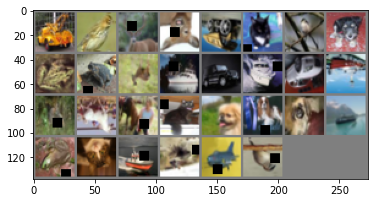

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = next(iter(trainloader))
images, labels = dataiter

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
import torch.optim as optim
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.001)

cuda


In [8]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 900 == 899:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 899))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: ignored